# Residual Network Architecture

In [ ]:
 from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.common.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.common.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

Using TensorFlow backend.


### ResNet-18 

In [ ]:
x=ResnetBuilder()
model = x.build_resnet_18((3,224,224),200)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

# CyclicLearning Rate

In [ ]:
from keras.callbacks import *
import numpy as np
class CyclicLR(Callback):
  def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

  def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
  def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
  def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
  def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:

clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))

clr = CyclicLR(base_lr=1e-4, max_lr=1e-3,
                    step_size=1562., scale_fn=clr_fn,
                    scale_mode='cycle')

## Unzipping 224x224 upscaled dataset

In [ ]:
!unzip -q "/content/drive/My Drive/ImageClassification/ImageClassification.zip"

warning [/content/drive/My Drive/ImageClassification/ImageClassification.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/My Drive/ImageClassification/ImageClassification.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #110205).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


In [ ]:
train_path = '/content/ImageClassification/train224'
valid_path = '/content/ImageClassification/val224/images_224'

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
import pandas as pd
val_data = pd.read_csv('/content/drive/My Drive/ImageClassification/val_annotations224.csv')
val_data.head(5)

,Image,Class
0,imagesval_0.JPEG.jpeg,n07753592
1,imagesval_1.JPEG.jpeg,n02883205
2,imagesval_2.JPEG.jpeg,n04532670
3,imagesval_3.JPEG.jpeg,n03160309
4,imagesval_4.JPEG.jpeg,n07583066


In [ ]:
train_generator = train_datagen.flow_from_directory('/content/ImageClassification/train224', target_size=(224, 224), batch_size=128, class_mode='categorical')
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/ImageClassification/val224/images_224', x_col='Image', y_col='Class', target_size=(224, 224),
                                                     class_mode='categorical', batch_size=128)

Found 90000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


# Compiling

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer = Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit_generator(train_generator, epochs=10, steps_per_epoch=len(train_generator), validation_steps=len(validation_generator), validation_data=validation_generator,callbacks = [clr])

Epoch 1/10
704/704 [==============================] - 1034s 1s/step - loss: 5.3044 - accuracy: 0.0888 - val_loss: 5.5746 - val_accuracy: 0.0749
Epoch 2/10
704/704 [==============================] - 1004s 1s/step - loss: 4.3843 - accuracy: 0.1691 - val_loss: 4.5834 - val_accuracy: 0.1546
Epoch 3/10
704/704 [==============================] - 1003s 1s/step - loss: 3.8900 - accuracy: 0.2321 - val_loss: 4.4358 - val_accuracy: 0.2125
Epoch 4/10
704/704 [==============================] - 989s 1s/step - loss: 3.3967 - accuracy: 0.3155 - val_loss: 2.9802 - val_accuracy: 0.3138
Epoch 5/10
704/704 [==============================] - 991s 1s/step - loss: 2.9628 - accuracy: 0.3967 - val_loss: 4.1324 - val_accuracy: 0.3665
Epoch 6/10
704/704 [==============================] - 989s 1s/step - loss: 2.9446 - accuracy: 0.3952 - val_loss: 3.0995 - val_accuracy: 0.3258
Epoch 7/10
704/704 [==============================] - 1000s 1s/step - loss: 2.9914 - accuracy: 0.3907 - val_loss: 4.0229 - val_accuracy: 0.

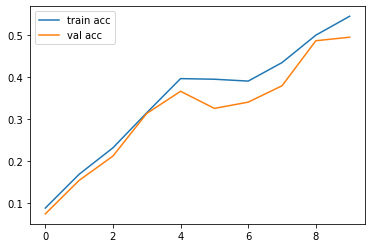

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['accuracy'], label='train acc')
plt.plot(model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


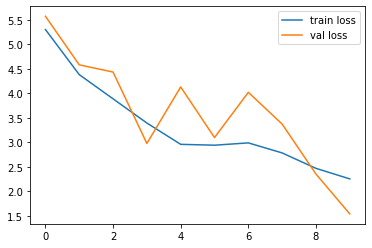

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Saving the model

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelWeightsfor10epoch.h5")
print("Saved model to disk")

Saved model to disk


# Loading the saved model

In [ ]:
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/ImageClassification/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/ImageClassification/modelWeightsfor10epoch.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
callbacks_ckpt = ModelCheckpoint(filepath='model_{epoch}',save_weights_only=True,monitor='val_acc', mode='max', save_best_only=True)

In [ ]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam
loaded_model.compile(optimizer = Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
loaded_model.fit_generator(train_generator, epochs=10, steps_per_epoch=len(train_generator), validation_steps=len(validation_generator), validation_data=validation_generator,callbacks = [clr,callbacks_ckpt])

Epoch 1/10
704/704 [==============================] - 1464s 2s/step - loss: 2.3809 - accuracy: 0.5141 - val_loss: 3.3653 - val_accuracy: 0.3400
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


704/704 [==============================] - 1426s 2s/step - loss: 2.7696 - accuracy: 0.4408 - val_loss: 4.5208 - val_accuracy: 0.2637
Epoch 3/10
704/704 [==============================] - 1408s 2s/step - loss: 2.8726 - accuracy: 0.4355 - val_loss: 3.2663 - val_accuracy: 0.3668
Epoch 4/10
704/704 [==============================] - 1427s 2s/step - loss: 2.5540 - accuracy: 0.5029 - val_loss: 2.8199 - val_accuracy: 0.4757
Epoch 5/10
704/704 [==============================] - 1428s 2s/step - loss: 2.1466 - accuracy: 0.5884 - val_loss: 2.3426 - val_accuracy: 0.4973
Epoch 6/10
704/704 [==============================] - 1421s 2s/step - loss: 2.2115 - accuracy: 0.5674 - val_loss: 3.1357 - val_accuracy: 0.3890
Epoch 7/10
704/704 [==============================] - 1416s 2s/step - loss: 2.3819 - accuracy: 0.5338 - val_loss: 3.4335 - val_accuracy: 0.4161
Epoch 8/10
704/704 [==============================] - 1454s 2s/step - loss: 2.2277 - accuracy: 0.5707 - val_loss: 2.1845 - val_accuracy: 0.4716
Epo

In [ ]:
loaded_model.save_weights("modelWeightsfor10epoch02.h5")